In [1]:
import time
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, inspect
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
import pickle


In [2]:
#Unwraping the .db to pandas

engine = create_engine(r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
db_connect = engine.connect()
inspector = inspect(engine)
db_tables = inspector.get_table_names()
print(db_tables)

['diamonds_city', 'diamonds_clarity', 'diamonds_color', 'diamonds_cut', 'diamonds_dimensions', 'diamonds_properties', 'diamonds_transactional']


In [3]:
#Read all tables though sqlalchemy and pandas

city = pd.read_sql_table('diamonds_city', r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
#print(city)
clarity = pd.read_sql_table('diamonds_clarity',r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
#print(clarity)
color = pd.read_sql_table('diamonds_color',r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
#print(color)
cut = pd.read_sql_table('diamonds_cut',r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
#print(cut)
dimensions = pd.read_sql_table('diamonds_dimensions',r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
#print(dimensions)
properties = pd.read_sql_table('diamonds_properties',r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
#print(properties)
transactional = pd.read_sql_table('diamonds_transactional',r"sqlite:///C:\Users\jcarl\Proyect_ML-Diamonds-\dataset\diamonds_train.db")
#print(transactional)

In [4]:
#Denormalizing the model
denormalized= pd.merge(city,transactional)
denormalized2= pd.merge(denormalized,dimensions)
denormalized3= pd.merge(denormalized2, properties)
denormalized4= pd.merge(denormalized3,color)
denormalized5= pd.merge(denormalized4,clarity)
denormalized6= pd.merge(denormalized5,cut)

#Dropping columns

df_diamonds = denormalized6.drop(columns=["city_id","index_id","cut_id","color_id","clarity_id"], inplace=True)
df_diamonds = denormalized6
df_diamonds


,city,price,carat,depth,table,x,y,z,color,clarity,cut
0,Amsterdam,3733,1.01,65.2,56.0,6.23,6.19,4.05,H,VS2,Fair
1,Amsterdam,1207,0.43,62.1,56.0,4.85,4.87,3.02,D,VS1,Ideal
2,Amsterdam,12932,1.30,61.3,56.0,7.03,7.06,4.32,G,IF,Ideal
3,Amsterdam,743,0.35,62.0,53.9,4.50,4.53,2.80,H,VVS1,Ideal
4,Amsterdam,3715,0.90,62.2,54.0,6.13,6.21,3.84,E,SI2,Very Good
...,...,...,...,...,...,...,...,...,...,...,...
40450,Luxembourg,1781,0.51,62.0,56.0,5.15,5.11,3.18,E,VS2,Ideal
40451,Luxembourg,5215,1.36,62.6,58.0,7.00,7.12,4.42,J,SI2,Very Good
40452,Luxembourg,665,0.32,62.0,55.0,4.43,4.44,2.75,G,VS1,Ideal
40453,Luxembourg,1173,0.57,62.5,55.0,5.28,5.32,3.31,I,SI1,Ideal


In [5]:
#Exploring if there are null values

df_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   city     40455 non-null  object 
 1   price    40455 non-null  int64  
 2   carat    40455 non-null  float64
 3   depth    40455 non-null  float64
 4   table    40455 non-null  float64
 5   x        40455 non-null  float64
 6   y        40455 non-null  float64
 7   z        40455 non-null  float64
 8   color    40455 non-null  object 
 9   clarity  40455 non-null  object 
 10  cut      40455 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 3.4+ MB


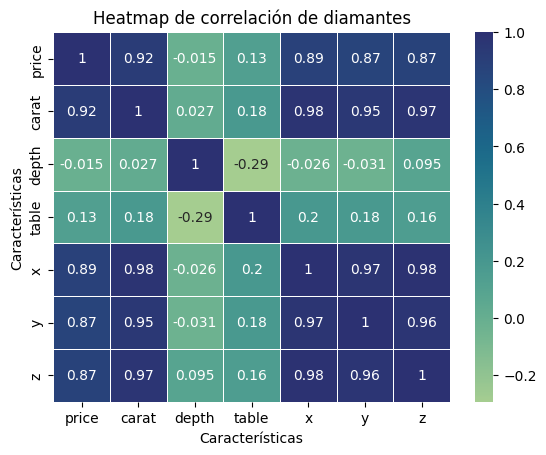

In [6]:
#Numerical correlation heatmap

df_diamonds_num = df_diamonds.loc[:,['price','carat','depth','table','x','y','z']]

sns.heatmap(df_diamonds_num.corr(), cmap='crest',annot=True, linewidths=0.5, cbar=True)

plt.title('Heatmap de correlación de diamantes')
plt.xlabel('Características')
plt.ylabel('Características')
plt.show()

In [7]:
# Categorical data analyser

def cat_var(df, cols):
    '''
    Return: a Pandas dataframe object with the following columns:
        - "categorical_variable" => every categorical variable include as an input parameter (string).
        - "number_of_possible_values" => the amount of unique values that can take a given categorical variable (integer).
        - "values" => a list with the posible unique values for every categorical variable (list).

    Input parameters:
        - df -> Pandas dataframe object: a dataframe with categorical variables.
        - cols -> list object: a list with the name (string) of every categorical variable to analyse.
    '''
    cat_list = []
    for col in cols:
        cat = df[col].unique()
        cat_num = len(cat)
        cat_dict = {"categorical_variable":col,
                    "number_of_possible_values":cat_num,
                    "values":cat}
        cat_list.append(cat_dict)
    df = pd.DataFrame(cat_list).sort_values(by="number_of_possible_values", ascending=False)
    return df.reset_index(drop=True)

In [8]:
#Feature analisis
df_diamonds_cat = df_diamonds.loc[:,['clarity','color','cut']]
col_diamonds = list(df_diamonds_cat.columns)
cat_diamonds = cat_var(df_diamonds_cat,col_diamonds)
cat_diamonds

,categorical_variable,number_of_possible_values,values
0,clarity,8,"[VS2, VS1, IF, VVS1, SI2, SI1, VVS2, I1]"
1,color,7,"[H, D, G, E, I, F, J]"
2,cut,5,"[Fair, Ideal, Very Good, Premium, Good]"


In [9]:
df_diamonds_cat

,clarity,color,cut
0,VS2,H,Fair
1,VS1,D,Ideal
2,IF,G,Ideal
3,VVS1,H,Ideal
4,SI2,E,Very Good
...,...,...,...
40450,VS2,E,Ideal
40451,SI2,J,Very Good
40452,VS1,G,Ideal
40453,SI1,I,Ideal


In [10]:
#Metrics
#explorings data metrics of x
print('mean:',df_diamonds['x'].mean())
print('min:', df_diamonds['x'].min())
print('max:', df_diamonds['x'].max())
print('median:', df_diamonds['x'].median())
print('std:', df_diamonds['x'].std())

#explorings data metrics of y
print('\n')
print('mean:',df_diamonds['y'].mean())
print('min:', df_diamonds['y'].min())
print('max:', df_diamonds['y'].max())
print('median:', df_diamonds['y'].median())
print('std:', df_diamonds['y'].std())

#explorings data metrics of z
print('\n')
print('mean:',df_diamonds['z'].mean())
print('min:', df_diamonds['z'].min())
print('max:', df_diamonds['z'].max())
print('median:', df_diamonds['z'].median())
print('std:', df_diamonds['z'].std())


mean: 5.72939166975652
min: 0.0
max: 10.23
median: 5.69
std: 1.1244526926185892


mean: 5.732818687430478
min: 0.0
max: 58.9
median: 5.71
std: 1.1466498960912597


mean: 3.5371536274873314
min: 0.0
max: 8.06
median: 3.52
std: 0.6970615911262102


In [11]:
#Imputer 

df_diamonds[['x', 'y', 'z']] = df_diamonds[['x','y','z']].replace(0.0,np.nan)

imputer = SimpleImputer(missing_values = np.nan, strategy='mean')

df_diamonds[['x','y','z']] = imputer.fit_transform(df_diamonds[['x','y','z']])

In [12]:
#Checking

#Metrics
#explorings data metrics of x
print('min:', df_diamonds['x'].min())

#explorings data metrics of y
print('\n')
print('min:', df_diamonds['y'].min())

#explorings data metrics of z
print('\n')
print('min:', df_diamonds['z'].min())


min: 3.77


min: 3.72


min: 1.07


In [16]:
#Manual Encoding
clarity_mapped = {'I1':1.0, 'SI2':2.0, 'SI1':3.0, 'VS2':4.0, 'VS1':5.0, 'VVS2':6.0, 'VVS1':7.0, 'IF':8.0}
color_mapped = {'J':1.0, 'I':2.0, 'H':3.0, 'G':4.0, 'F':5.0, 'E':6.0, 'D':7.0}
cut_mapped = {'Fair':1.0, 'Good':2.0, 'Very Good':3.0, 'Premium':4.0, 'Ideal':5.0}

#mapping and dropping columns
df_diamonds_cat['clarity_encoded'] = df_diamonds_cat['clarity'].map(clarity_mapped)
df_diamonds_cat['color_encoded'] = df_diamonds_cat['color'].map(color_mapped)
df_diamonds_cat['cut_encoded'] = df_diamonds_cat['cut'].map(cut_mapped)
df_diamonds_cat = df_diamonds_cat.drop(columns=['clarity','color','cut'])

df_diamonds_cat.head()


,clarity_encoded,color_encoded,cut_encoded
0,4.0,3.0,1.0
1,5.0,7.0,5.0
2,8.0,4.0,5.0
3,7.0,3.0,5.0
4,2.0,6.0,3.0


In [17]:
#data-merge

encoded_df = pd.merge(df_diamonds_num,df_diamonds_cat,left_index=True, right_index=True)


In [18]:
encoded_df.head()

,price,carat,depth,table,x,y,z,clarity_encoded,color_encoded,cut_encoded
0,3733,1.01,65.2,56.0,6.23,6.19,4.05,4.0,3.0,1.0
1,1207,0.43,62.1,56.0,4.85,4.87,3.02,5.0,7.0,5.0
2,12932,1.30,61.3,56.0,7.03,7.06,4.32,8.0,4.0,5.0
3,743,0.35,62.0,53.9,4.50,4.53,2.80,7.0,3.0,5.0
4,3715,0.90,62.2,54.0,6.13,6.21,3.84,2.0,6.0,3.0


In [19]:
#Feature engineering

#add column quality (Quality is measured based on four criteria: color, clarity, cut quality and carat weight.)
weight_carat = 0.20
weight_clarity = 0.20
weight_color = 0.35
weight_cut = 0.20
encoded_df['quality'] = (weight_carat * encoded_df['carat'] +
                         weight_clarity * encoded_df['clarity_encoded'] +
                         weight_color * encoded_df ['color_encoded'] +
                         weight_color * encoded_df['cut_encoded'])




#add column volume (by multiplaying x,y and z)
encoded_df['volume'] = (0.33 * encoded_df['x'] +
                        0.33 * encoded_df['y'] +
                        0.33 * encoded_df['z'])

#add column proportion (by adding depth an table)
encoded_df['proportion'] = (0.5 * encoded_df['depth'] +
                            0.5 * encoded_df['table'])

encoded_df


,price,carat,depth,table,x,y,z,clarity_encoded,color_encoded,cut_encoded,quality,volume,proportion
0,3733,1.01,65.2,56.0,6.23,6.19,4.05,4.0,3.0,1.0,2.402,5.4351,60.60
1,1207,0.43,62.1,56.0,4.85,4.87,3.02,5.0,7.0,5.0,5.286,4.2042,59.05
2,12932,1.30,61.3,56.0,7.03,7.06,4.32,8.0,4.0,5.0,5.010,6.0753,58.65
3,743,0.35,62.0,53.9,4.50,4.53,2.80,7.0,3.0,5.0,4.270,3.9039,57.95
4,3715,0.90,62.2,54.0,6.13,6.21,3.84,2.0,6.0,3.0,3.730,5.3394,58.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,1781,0.51,62.0,56.0,5.15,5.11,3.18,4.0,6.0,5.0,4.752,4.4352,59.00
40451,5215,1.36,62.6,58.0,7.00,7.12,4.42,2.0,1.0,3.0,2.072,6.1182,60.30
40452,665,0.32,62.0,55.0,4.43,4.44,2.75,5.0,4.0,5.0,4.214,3.8346,58.50
40453,1173,0.57,62.5,55.0,5.28,5.32,3.31,3.0,2.0,5.0,3.164,4.5903,58.75


In [21]:
#Features and target

X = encoded_df
X = X.drop(columns='price')

y= df_diamonds.loc[:,'price']
print(X.shape, y.shape)

(40455, 12) (40455,)


In [22]:
#Renaming because the kernel gets mad, it doesnt recognize columns as str, although they are

X = X.rename(columns={'carat':'carat',
                      'depth':'depth',
                      'table':'table',
                      'x':'x',
                      'y':'y',
                      'z':'z',
                      'clarity_encoded': 'clarity_encoded',
                      'color_encoded':'color_encoded',
                      'cut_encoded':'cut_encoded',
                      'quality': 'quality',
                      'volume': 'volume',
                      'proportion': 'proportion'
                     }
            )

In [23]:
#Scaling
scaler = RobustScaler()
scaler = scaler.fit_transform(X)

In [24]:
scaler

array([[ 0.484375  ,  2.26666667, -0.33333333, ..., -1.35559567,
         0.32696391,  0.73333333],
       [-0.421875  ,  0.2       , -0.33333333, ...,  1.24729242,
        -0.46496815, -0.3       ],
       [ 0.9375    , -0.33333333, -0.33333333, ...,  0.99819495,
         0.7388535 , -0.56666667],
       ...,
       [-0.59375   ,  0.13333333, -0.66666667, ...,  0.27978339,
        -0.70276008, -0.66666667],
       [-0.203125  ,  0.46666667, -0.66666667, ..., -0.66787004,
        -0.21656051, -0.5       ],
       [-0.65625   ,  0.        , -1.        , ...,  0.40794224,
        -0.83227176, -1.06666667]])

In [25]:
X = pd.DataFrame(scaler)

In [26]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.484375,2.266667,-0.333333,0.295082,0.263736,0.471111,0.0,-0.333333,-1.5,-1.355596,0.326964,0.733333
1,-0.421875,0.200000,-0.333333,-0.459016,-0.461538,-0.444444,0.5,1.000000,0.5,1.247292,-0.464968,-0.300000
2,0.937500,-0.333333,-0.333333,0.732240,0.741758,0.711111,2.0,0.000000,0.5,0.998195,0.738854,-0.566667
3,-0.546875,0.133333,-1.033333,-0.650273,-0.648352,-0.640000,1.5,-0.333333,0.5,0.330325,-0.658174,-1.033333
4,0.312500,0.266667,-1.000000,0.240437,0.274725,0.284444,-1.0,0.666667,-0.5,-0.157040,0.265393,-0.933333


In [27]:
X = X.rename(columns={0:'carat',
                      1:'depth',
                      2:'table',
                      3:'x',
                      4:'y',
                      5:'z',
                      6: 'clarity_encoded',
                      7:'color_encoded',
                      8:'cut_encoded',
                      9: 'quality',
                      10: 'volume',
                      11: 'proportion'
                     }
            )

In [28]:
X.head()

,carat,depth,table,x,y,z,clarity_encoded,color_encoded,cut_encoded,quality,volume,proportion
0,0.484375,2.266667,-0.333333,0.295082,0.263736,0.471111,0.0,-0.333333,-1.5,-1.355596,0.326964,0.733333
1,-0.421875,0.200000,-0.333333,-0.459016,-0.461538,-0.444444,0.5,1.000000,0.5,1.247292,-0.464968,-0.300000
2,0.937500,-0.333333,-0.333333,0.732240,0.741758,0.711111,2.0,0.000000,0.5,0.998195,0.738854,-0.566667
3,-0.546875,0.133333,-1.033333,-0.650273,-0.648352,-0.640000,1.5,-0.333333,0.5,0.330325,-0.658174,-1.033333
4,0.312500,0.266667,-1.000000,0.240437,0.274725,0.284444,-1.0,0.666667,-0.5,-0.157040,0.265393,-0.933333


In [29]:
# Train + test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

X_train: (32364, 12), X_test: (8091, 12), y_train: (32364,), y_test: (8091,)
X_train: <class 'pandas.core.frame.DataFrame'>, X_test: <class 'pandas.core.frame.DataFrame'>, y_train: <class 'pandas.core.series.Series'>, y_test: <class 'pandas.core.series.Series'>


In [30]:
#Model training
model = xgb.XGBRegressor(booster= 'dart',objective='reg:squarederror', colsample_bytree= 0.6, learning_rate= 0.1, max_depth= 5, n_estimators= 480, subsample= 1.0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'Feature importance: {model.feature_importances_}')

RMSE: 521.800094144522
Feature importance: [0.18051001 0.00128666 0.00101594 0.00526178 0.40796417 0.01324425
 0.0586777  0.01907491 0.0029259  0.02904337 0.28001463 0.00098066]


In [ ]:
# Grid search for XGBOOST

param_grid_tree = {
    'booster': 'gbtree',
    'n_estimators': [470, 480, 490],
    'learning_rate': [0.095, 0.099, 0.1],
    'max_depth': [5, 6, 7],
    'subsample': [0.98, 0.99, 1.0],
    'colsample_bytree': [0.4, 0.5,0.6],
    'eta': [0.1,0.3,0.5],
    'gamma': [0.1,0.3,0.5],
    'lambda': [0.1,0.5,1.0], #L2 regularization
    'alpha': [0.1,0.5,1.0], #L1 regularization
    'sampling_method': ['uniform', 'subsample','gradient_based'] 
}


param_grid_linear = {
    'booster': 'gblinear',
    'n_estimators': [470, 480, 490],
    'learning_rate': [0.095, 0.099, 0.1],
    'max_depth': [5, 6, 7],
    'subsample': [0.98, 0.99, 1.0],
    'colsample_bytree': [0.4, 0.5,0.6],
    'eta': [0.1,0.3,0.5],
    'gamma': [0.1,0.3,0.5],
    'lambda': [0.1,0.5,1.0], #L2 regularization
    'alpha': [0.1,0.5,1.0], #L1 regularization
    'sampling_method': ['uniform', 'subsample','gradient_based'] 
}

param_grid_dart = {
    'booster': ['dart'],
    'objective': ['reg:squarederror'],
    'n_estimators': [500, 600,700], #500 the best, i asumme 480 as before
    'learning_rate': [0.08, 0.1, 0.15], #0.1 the best
    'max_depth': [3, 4, 5], # 5 the best
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1], # 1 the best i assume
    'gamma': [0.1,0.3,0.5],
    'lambda': [0.2,0.5,1.0], #1.0
    'alpha': [0.2,0.4,0.6], #0.4
    'colsample_bytree': [0.5, 0.7, 1], #0.6 the best i assume
    'rate_drop': [0.1, 0.3, 0.5],
    'skip_drop': [0.3, 0.5, 0.7]
    'normalize_type': ['tree', 'forest'] # tree
}

grid_search = GridSearchCV(model,
                           param_grid_dart,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X,y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')


In [31]:
# Cross validation

scores = cross_val_score(model, 
                         X, 
                         y, 
                         scoring='neg_root_mean_squared_error', 
                         cv=5,
                         n_jobs=-1)

print(type(model), '\n')
print(scores, '\n')
print(np.mean(-scores), '\n')

<class 'xgboost.sklearn.XGBRegressor'> 

[-529.08342471 -522.78456783 -545.90362705 -520.53416635 -535.20982187] 

530.7031215611006 



In [ ]:
#Save model

filename = '../models/xgboost_101.sav'
pickle.dump(model, open(filename, 'wb'))
print('Your model has been saved with  pickle!!!')